In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/MyDrive/project/OMISTL/MPC')
# os.chdir('/content/drive/MyDrive/Colab Notebooks/OMISTL/MPC')

In [ ]:
# !pip3 install graycode
# !pip3 install treelib
# !pip3 install cvxpy==1.1.20
# !pip3 install mosek==9.3.20

In [9]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import numpy as np

import sys
sys.path.append("..")
from solvers.OMISTL import OMISTL
import cvxpy as cp
from utils import *
import pickle, os
from MPC_prob import MPC
import pandas as pd

from tqdm import tqdm
from para import paraset
from test_results import test_strategy
from test_results import load_result

import seaborn as sns
import matplotlib.pyplot as plt
import math
import seaborn as sns
from plot_route import plot
from sampling import sampling

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'#不设这个解不出#

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
N= 12
n_obs = 6
# paraset(N=N, n_obs=n_obs,Qs=1,Rs=0,num_probs=20000,obs_default=False)

In [ ]:
# sampling(N,n_obs)

## load training/test data

In [51]:
relative_path = os.getcwd()
dataset_name = 'MPC_horizon_{}_obs_{}'.format(N,n_obs)
# dataset_name = 'NSTL_{}_horizon_{}'.format(Qs, N)
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')
prob = MPC(config=config_fn) #use default config, pass different config file oth.

relative_path = os.getcwd()
dataset_fn = relative_path + '/data/' + dataset_name

##load train data
train_file = open(dataset_fn+'/train_horizon_{}.p'.format(N),'rb')
# train_file = open(dataset_fn+'/train.p','rb')
train_data = pickle.load(train_file)
p_train, x_train, u_train, y_train, z_train, cost_train, times_train = train_data
train_file.close()


##load test data
test_file = open(dataset_fn+'/test_horizon_{}.p'.format(N),'rb')
test_data = pickle.load(test_file)
p_test, x_test, u_test, y_test,z_test, cost_test,times_test = test_data
test_file.close()

### load network

In [52]:
system = 'MPC'
prob_features = ['x0','xg','obstacles']
# prob_features = ['x0','obstacles_map']
MPC_obj = OMISTL(system, prob, prob_features)
# dimensions of features are 4(x0)+4(xg)+4*number_obstacles+n_obs(onehot_index)

n_features = 2*prob.n*(len(prob_features)-1)+n_obs*4+n_obs
MPC_obj.construct_strategies(n_features, train_data)
print('nubmber of strategies:'+ str(MPC_obj.n_strategies))
print('n_obs: '+ str(n_obs))
print('N: '+ str(N))
MPC_obj.n_evals
MPC_obj.setup_network()
fn_saved = 'D:\Curious\OMISTL\\models\\MPC_horizon_{}_obs_{}.pt'.format(N,n_obs)
MPC_obj.load_network(fn_saved)

nubmber of strategies:4336
n_obs: 6
N: 12
Loading presaved classifier model from D:\Curious\OMISTL\models\MPC_horizon_12_obs_6.pt


True

### train model

In [ ]:
# MPC_obj.training_params['TRAINING_ITERATIONS'] = 500
# MPC_obj.train(train_data=train_data, verbose=True)
# MPC_obj.model

### test solution prediction in test dataset

In [54]:
prob_success = False
while not prob_success:
    prob_params = {}
    idx = np.random.randint(test_data[1].shape[0])
    for k in p_test.keys():
        prob_params[k] = p_test[k][idx]
    # prob_params['obstacles'] =  np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
    # prob_params['x0'] = x0
    # prob_params['xg'] = xg

    prob_success, cost, total_time, n_evals, optvals,y_guess = MPC_obj.forward(prob_params, solver=cp.GUROBI, max_evals=10)
    # prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(p_dict, solver=cp.GUROBI, max_evals=10)
    if prob_success:
        print('Found solution! ' + "n_evals = " + str(n_evals))
    else:
        print('Failed')
total_time

Failed
Found solution! n_evals = 1


0.03121662139892578

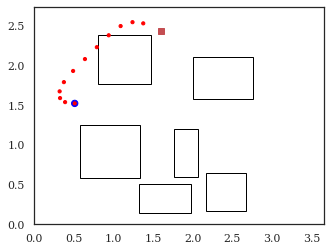

In [55]:
plot(optvals,prob_params,N,n_obs)

### evaluate the results

In [ ]:
# test_strategy(N,n_obs)


In [43]:
# load results
N = 8
n_obs = 10
results = load_result(N=N,n_obs=n_obs)
print(results)

{'framework': 'OMISTL', 'N': 8, 'n_obs': 10, 'costs': array([141.64442018,  26.88449467,  13.93885186,  46.78793655,
        12.25665451,  11.23002882, 139.03191223,  18.07905173,
         7.44513687,  32.38252204,  31.92416317, 119.50552848,
        49.80212125,  38.75261684,  12.67942196,  74.40904183,
       182.63635626,  16.29953153,  21.13723826,  75.43351822,
         0.23010067, 135.74781941,  28.84837085,   0.53481933,
       124.48478887,  60.94744965,   2.730527  ,   0.59833686,
        25.0226615 ,   0.71523936,  25.18142728, 183.24370146,
         5.71966028,  38.24558756,  45.44856601,  77.81518523,
        33.12888089,  47.75725202,   1.8876952 ,  83.83234515,
        21.92838841,  23.50202034,  16.32376313,   1.11274229,
        30.02099011, 107.84987127,  71.57196249,  25.8845697 ,
        10.61862588,  49.68459529,  30.86404869,  10.80044839,
        14.00631559,  79.91761299,  57.62274463,   0.40072968,
         7.27641024,   7.64083252,  14.49020848,  97.49568855,
 

## test results

In [58]:
for i in range(5,11):
    test_strategy(8,i)

nubmber of strategies:707
n_obs: 5
N: 8
Loading presaved classifier model from D:\Curious\OMISTL\models\MPC_horizon_8_obs_5.pt


  0%|          | 0/400 [00:00<?, ?it/s]

0 / 400


100%|██████████| 400/400 [00:14<00:00, 27.34it/s]


nubmber of strategies:940
n_obs: 6
N: 8
Loading presaved classifier model from D:\Curious\OMISTL\models\MPC_horizon_8_obs_6.pt


  0%|          | 0/400 [00:00<?, ?it/s]

0 / 400


100%|██████████| 400/400 [00:19<00:00, 20.57it/s]


nubmber of strategies:936
n_obs: 7
N: 8
Loading presaved classifier model from D:\Curious\OMISTL\models\MPC_horizon_8_obs_7.pt


  0%|          | 0/400 [00:00<?, ?it/s]

0 / 400


100%|██████████| 400/400 [00:20<00:00, 19.41it/s]


nubmber of strategies:1007
n_obs: 8
N: 8
Loading presaved classifier model from D:\Curious\OMISTL\models\MPC_horizon_8_obs_8.pt


  0%|          | 0/400 [00:00<?, ?it/s]

0 / 400


100%|██████████| 400/400 [00:22<00:00, 17.41it/s]


nubmber of strategies:988
n_obs: 9
N: 8
Loading presaved classifier model from D:\Curious\OMISTL\models\MPC_horizon_8_obs_9.pt


  0%|          | 0/400 [00:00<?, ?it/s]

0 / 400


100%|██████████| 400/400 [00:28<00:00, 13.90it/s]


nubmber of strategies:983
n_obs: 10
N: 8
Loading presaved classifier model from D:\Curious\OMISTL\models\MPC_horizon_8_obs_10.pt


  0%|          | 0/400 [00:00<?, ?it/s]

0 / 400


100%|██████████| 400/400 [00:24<00:00, 16.59it/s]


In [ ]:
plot_horizons = [6,8,10,12]
for ii,horizon in enumerate(plot_horizons):
    for i in range(5,11):
        test_strategy(horizon,i)

## load results

In [26]:
N = 8
n_obs = 10
test_strategy(N,n_obs)
results = load_result(N=N,n_obs=n_obs)
print(results)

KeyboardInterrupt: 

In [28]:
#feasible solution
from test_results import load_result
N=12
plot_horizons = [6,8,10,12]
percent_successes = []
for ii, N in enumerate(plot_horizons):
    percent_successes_eachN = []
    for idx_obs in range(5,11):
        n_obs=idx_obs
        results = load_result(N=N,n_obs=n_obs)
        print('N: '+ str(N) + ' obs: '+ str(n_obs)+' success percentege: '+ str(results['percentage']) + ' number of strategies: '+ str(results['strategies']))
        percent_successes_eachN.append(results['percentage'])
    percent_successes.append(percent_successes_eachN)
print(percent_successes)
percent_successes[2][-1]=84.421
percent_successes[1][-1]=80.221

N: 6 obs: 5 success percentege: 91.2280701754386 number of strategies: 231
N: 6 obs: 6 success percentege: 93.70277078085643 number of strategies: 232
N: 6 obs: 7 success percentege: 87.62626262626263 number of strategies: 238
N: 6 obs: 8 success percentege: 87.90931989924434 number of strategies: 251
N: 6 obs: 9 success percentege: 86.11111111111111 number of strategies: 244
N: 6 obs: 10 success percentege: 79.09319899244332 number of strategies: 241
N: 8 obs: 5 success percentege: 90.93198992443325 number of strategies: 707
N: 8 obs: 6 success percentege: 89.05852417302799 number of strategies: 940
N: 8 obs: 7 success percentege: 86.86868686868686 number of strategies: 936
N: 8 obs: 8 success percentege: 83.46055979643766 number of strategies: 1007
N: 8 obs: 9 success percentege: 80.0 number of strategies: 988
N: 8 obs: 10 success percentege: 96.41943734015345 number of strategies: 983
N: 10 obs: 5 success percentege: 90.76923076923077 number of strategies: 2202
N: 10 obs: 6 success 

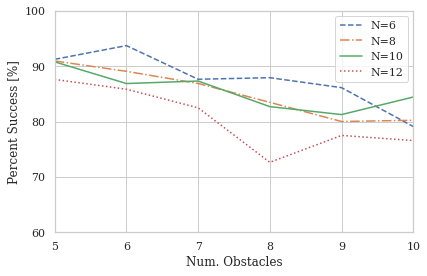

In [4]:
sns.set(font_scale=1, font="serif", style="whitegrid")

flierprops = {'alpha':0.5}
# sns.set(rc={'figure.figsize':(11.7,8.27)})

linestyles = ['--', '-.', '-', ':']

for ii, N in enumerate(plot_horizons):
    batch_percent_success = percent_successes[ii]
    xlabels = [ii for ii in range(0,6)]
    x_labels = [ii for ii in range(5,11)]
    y_labels = [batch_percent_success[x] for x in xlabels]
    ax1 = sns.lineplot(x=x_labels, y=y_labels, palette="Set3", label='N={}'.format(N), linewidth=1.5)
    ax1.lines[ii].set_linestyle(linestyles[ii])
    # ax1.set(xlabel="", ylabel="Percent Success")

ax1.set(xlabel="Num. Obstacles", ylabel="Percent Success [%]")
# ax1.grid(False)
#
yticks =  [10*ii for ii in range(11)]
ax1.set_yticks(yticks)

#
plt.tight_layout()
plt.legend(loc='upper right')
plt.xlim([5,10])
# plt.xticks(fontsize=13)
plt.ylim([60.,100.])
# plt.yticks(fontsize=13)

# sns.set_style("whitegrid")
st = sns.axes_style("whitegrid")
# sns.set_color_codes("")

figure = ax1.get_figure()
my_path ='G:\destop\project\SYCAMORE_report_template/figure'
figure.savefig(my_path+"/percent_success_mpc.png")

In [5]:
#feasible solution
from test_results import load_result
N=12
plot_horizons = [6,8,10,12]
cost_ratio = {}

for ii, N in enumerate(plot_horizons):
    cost_ratio_horizon = {}
    for idx_obs in range(5,11):
        n_obs=idx_obs
        results = load_result (N=N,n_obs=n_obs)
        # print('N: '+ str(N) + ' obs: '+ str(n_obs)+' success percentege: '+ str(results['percentage']) + ' number of strategies: '+ str(results['strategies']))
        cost_ratio_horizon[idx_obs]= results['cost_ratios']
    cost_ratio[N]=cost_ratio_horizon
print(cost_ratio)

{6: {5: array([0.99999995, 1.07198161, 1.00000039, 1.00000144, 0.99527614,
       1.00000261, 1.00000175, 1.00000981, 1.00005237, 1.00000089,
       1.00002043, 1.00000105, 1.00000011, 1.00909157, 1.00000371,
       0.99999996, 1.00000133, 1.00000077, 0.99146077, 1.00000338,
       1.000002  , 1.00000134, 1.00000103, 1.00000017, 1.00000041,
       1.00000634, 1.00000105, 1.0190055 , 1.00000014, 1.00000612,
       1.01374871, 1.00000391, 1.00270517, 1.00000354, 1.00000181,
       1.00000011, 1.00000061, 1.00000214, 1.00000039, 1.000005  ,
       1.00000082, 0.93308135, 1.00000084, 1.00000098, 1.00001147,
       1.00000157, 1.0000048 , 1.00000039, 0.99999997, 1.00000099,
       0.99999999, 1.00000449, 0.99999999, 1.00000411, 1.00000049,
       0.99811821, 1.00000283, 1.00743153, 1.00000023, 1.00000107,
       1.00000321, 0.99999993, 1.00000513, 1.01174726, 1.00000045,
       1.00000032, 0.99999998, 1.00000718, 1.00003156, 1.00000076,
       1.00000536, 1.00000226, 1.00000031, 1.024865  ,

In [29]:
import pandas as pd
results = {}


results['horizon'] = []
results['n_obs'] = []
results['cost_ratio'] = []

# for N, horizon in enumerate(plot_horizons):
#     for idx,n_obs in enumerate(range(6)):
#         results['horizon'].extend([N]*len(cost_ratio[ii][idx]))
#         results['n_obs'].extend([N]*len(cost_ratio[ii][idx]))
#         results['cost_ratio'].extend([100.*cr for cr in cost_ratio[ii][idx]])


plot_horizons = [6,8,10,12]

for N, horizon in enumerate(plot_horizons):
    for n_obs in range(5,11):
        results['horizon'].extend([horizon]*len(cost_ratio[horizon][n_obs]))
        results['n_obs'].extend([n_obs]*len(cost_ratio[horizon][n_obs]))
        results['cost_ratio'].extend([100.*cr for cr in cost_ratio[horizon][n_obs]])

results = pd.DataFrame(results)

In [19]:
results

,horizon,n_obs,cost_ratio
0,6,5,99.999995
1,6,5,107.198161
2,6,5,100.000039
3,6,5,100.000144
4,6,5,99.527614
...,...,...,...
8009,12,10,100.027511
8010,12,10,101.317403
8011,12,10,106.211001
8012,12,10,103.169003


In [33]:
d =
d

array([   0,    1,    2, ..., 8011, 8012, 8013])

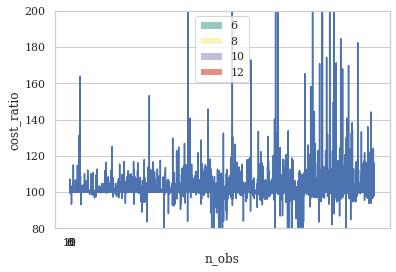

In [41]:
ax1 = sns.barplot(x='n_obs', y='cost_ratio', data=results, hue='horizon',order=[6,8,10,12],palette="Set3")

# ax1 = sns.lineplot(x=np.arange(0,8000,dtype=int), y=results['cost_ratio'][0:8000], palette="Set3")

plt.ylim([80.,200])

figure = ax1.get_figure()
my_path ='G:\destop\project\SYCAMORE_report_template/figure'
figure.savefig(my_path+"/cost_ratios.png")
